In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error
import time
from drone_sim_utilities import quat_to_euler
from drone_sim_utilities import body_to_nav
from drone_sim_utilities import process_trajectory
from drone_sim_utilities import test_model

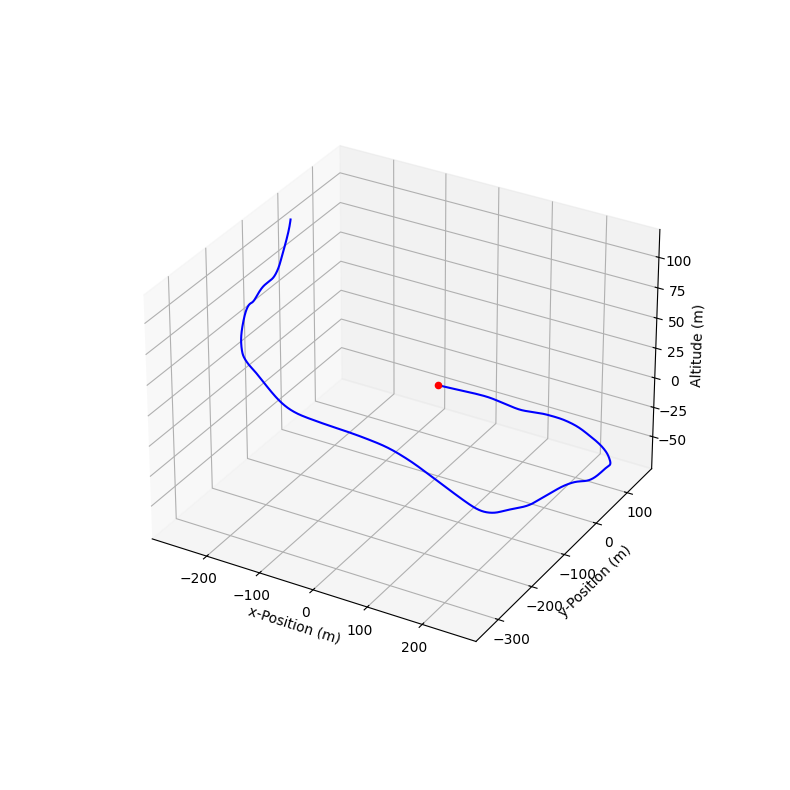

In [2]:
"""Plot a sample trajectory"""

f = h5py.File('data/drone_sim/sunny.hdf5')
traj_name = f"trajectory_0015"
traj = f[traj_name]

gnd_pos = traj["groundtruth"]["position"]

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot(gnd_pos[:,0], gnd_pos[:,1], gnd_pos[:,2], c="blue")
ax.scatter(gnd_pos[0,0], gnd_pos[0,1], gnd_pos[0,2], c="red", label="Start")
ax.set_xlabel("x-Position (m)")
ax.set_ylabel("y-Position (m)")
ax.set_zlabel("Altitude (m)")
ax.set_box_aspect(None, zoom=0.75)
plt.show()

Done i:0, j:0
Done i:0, j:1
Done i:0, j:2
Done i:0, j:3
Done i:0, j:4
Done i:1, j:0
Done i:1, j:1
Done i:1, j:2
Done i:1, j:3
Done i:1, j:4
Done i:2, j:0
Done i:2, j:1
Done i:2, j:2
Done i:2, j:3
Done i:2, j:4
Done i:3, j:0
Done i:3, j:1
Done i:3, j:2
Done i:3, j:3
Done i:3, j:4
Done i:4, j:0
Done i:4, j:1
Done i:4, j:2
Done i:4, j:3
Done i:4, j:4
Done i:5, j:0
Done i:5, j:1
Done i:5, j:2
Done i:5, j:3
Done i:5, j:4
Done i:6, j:0
Done i:6, j:1
Done i:6, j:2
Done i:6, j:3
Done i:6, j:4
Done i:7, j:0
Done i:7, j:1
Done i:7, j:2
Done i:7, j:3
Done i:7, j:4
Done i:8, j:0
Done i:8, j:1
Done i:8, j:2
Done i:8, j:3
Done i:8, j:4
Done i:9, j:0
Done i:9, j:1
Done i:9, j:2
Done i:9, j:3
Done i:9, j:4


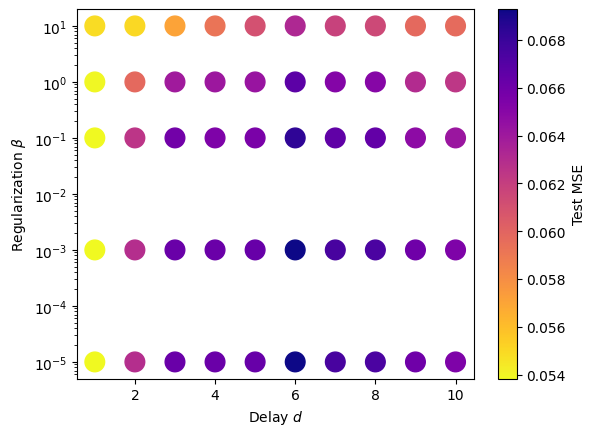

In [3]:
"""Hyperparameter testing for ARX"""

delay_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
beta_list = [1e-5, 1e-3, 1e-1, 1, 1e1]

results_ls = np.zeros(shape=(len(delay_list), len(beta_list)))

for d_i, d in enumerate(delay_list):
    f = h5py.File('data/drone_sim/sunny.hdf5')
    train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
                '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']

    data_params = {"MODEL_DELAY": d, 
                    "NORMALIZE_INPUT": 1, 
                    "NORMALIZE_OUTPUT": 1, 
                    "INPUT_ACCL": 1, 
                    "INPUT_GYRO": 1, 
                    "INPUT_ATTI": 1, 
                    "INPUT_VELO": 1,
                    "INPUT_POUT": 1,
                    "TRUE_ATT": 1,
                    "TRUE_VEL": 0,
                    "ACCEL_TO_NAV": 1
    }

    # Construct training data set
    Y_train = np.zeros(shape=(0,3))
    features = (data_params["INPUT_ACCL"] + data_params["INPUT_ATTI"] + data_params["INPUT_GYRO"] + data_params["INPUT_POUT"] + data_params["INPUT_VELO"])*3*data_params["MODEL_DELAY"]
    X_train = np.zeros(shape=(0,features))
    for i, traj_num in enumerate(train_set):
        traj_name = f"trajectory_{traj_num}"
        traj = f[traj_name]
        gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=True)
        # Construct training set
        model_delay = data_params["MODEL_DELAY"]
        dp_ = gps_delta.shape[0]-model_delay
        Y_train_ = np.zeros(shape=(dp_, 3))
        X_train_ = np.zeros(shape=(dp_, features))
        for i in range(dp_):
            Y_ = gps_delta[i+model_delay,:]
            Y_train_[i,:] = Y_
            X_ = np.zeros(shape=(1,0))
            if data_params["INPUT_ACCL"]:
                X_ = np.hstack((X_, [accel_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_GYRO"]:
                X_ = np.hstack((X_, [gyro_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_ATTI"]:
                X_ = np.hstack((X_, [attitude_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_VELO"]:
                X_ = np.hstack((X_, [velocity_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_POUT"]:
                X_ = np.hstack((X_, [gps_delta[i:i+model_delay,:].flatten()]))
            X_train_[i,:] = X_
        
        # Add to X and Y sets
        X_train = np.vstack((X_train, X_train_))
        Y_train = np.vstack((Y_train, Y_train_))
    
    for beta_j, beta in enumerate(beta_list):
        BETA_REG = beta
        dp_, features_ = X_train.shape
        _, outputs_ = Y_train.shape
        w_ls = np.zeros(shape=(outputs_, features_, 1))
        Y_train_ls = np.zeros(shape=(dp_, outputs_))
        for i in range(outputs_):
            w_ls[i,:,:] = np.expand_dims(np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,i], axis=1)
            Y_train_ls[:,i] = (X_train @ w_ls[i,:,:]).flatten()

        def model_ls(x):
            outputs_, _, _ = w_ls.shape
            dp_, _ = x.shape
            y_ = np.zeros(shape=(dp_, outputs_))
            for i in range(outputs_):
                y_[:,i] = (x @ w_ls[i,:,:]).flatten()
            return y_
        
        f = h5py.File('data/drone_sim/sunny.hdf5')
        test_set = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']
        mse_ls_avg = np.zeros(shape=(3,))
        for traj_num in test_set:
            traj_name = f"trajectory_{traj_num}"
            traj = f[traj_name]
            Y_test_ls, Y_test = test_model(traj=traj, model=model_ls, data_params=data_params)
            
            mse_ls = mean_squared_error(Y_test, Y_test_ls, multioutput="raw_values")
            
            mse_ls_avg = mse_ls_avg + mse_ls

        mse_ls_avg = mse_ls_avg/len(test_set)
        results_ls[d_i,beta_j] = (mse_ls_avg[0] + mse_ls_avg[1])/2
        print(f"Done i:{d_i}, j:{beta_j}")

# Convert to plottable format
plot_ls_results = np.zeros(shape=(len(delay_list)*len(beta_list),3))
index_counter = 0
for i, d in enumerate(delay_list):
    for j, beta in enumerate(beta_list):
        plot_ls_results[index_counter, :] = [d,beta,results_ls[i,j]]
        index_counter += 1

# Plot results
plt.scatter(plot_ls_results[:,0], plot_ls_results[:,1], c=plot_ls_results[:,2], cmap="plasma_r", s=200)
plt.yscale("log")
cbar = plt.colorbar()
cbar.set_label("Test MSE")
plt.xlabel(r"Delay $d$")
plt.ylabel(r"Regularization $\beta$")
plt.show()


Done i:0, j:0
Done i:0, j:1
Done i:0, j:2
Done i:0, j:3
Done i:0, j:4
Done i:0, j:5
Done i:1, j:0
Done i:1, j:1
Done i:1, j:2
Done i:1, j:3
Done i:1, j:4
Done i:1, j:5
Done i:2, j:0
Done i:2, j:1
Done i:2, j:2
Done i:2, j:3
Done i:2, j:4
Done i:2, j:5
Done i:3, j:0
Done i:3, j:1
Done i:3, j:2
Done i:3, j:3
Done i:3, j:4
Done i:3, j:5
Done i:4, j:0
Done i:4, j:1
Done i:4, j:2
Done i:4, j:3
Done i:4, j:4
Done i:4, j:5
Done i:5, j:0
Done i:5, j:1
Done i:5, j:2
Done i:5, j:3
Done i:5, j:4
Done i:5, j:5
Done i:6, j:0
Done i:6, j:1
Done i:6, j:2
Done i:6, j:3
Done i:6, j:4
Done i:6, j:5
Done i:7, j:0
Done i:7, j:1
Done i:7, j:2
Done i:7, j:3
Done i:7, j:4
Done i:7, j:5
Done i:8, j:0
Done i:8, j:1
Done i:8, j:2
Done i:8, j:3
Done i:8, j:4
Done i:8, j:5
Done i:9, j:0
Done i:9, j:1
Done i:9, j:2
Done i:9, j:3
Done i:9, j:4
Done i:9, j:5


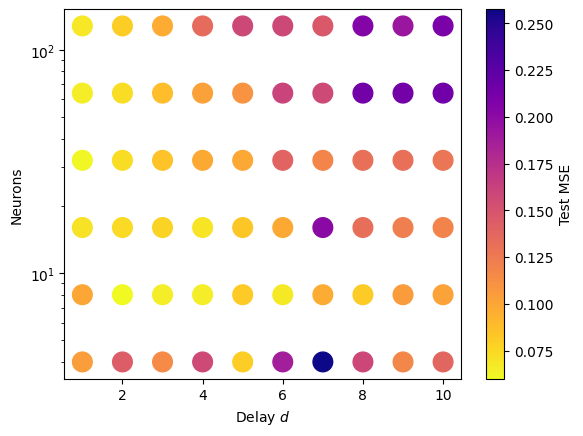

In [4]:
"""Neural network hyperparameter search"""

delay_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
neuron_list = [4, 8, 16, 32, 64, 128]

results_nn = np.zeros(shape=(len(delay_list), len(neuron_list)))

for d_i, d in enumerate(delay_list):
    f = h5py.File('data/drone_sim/sunny.hdf5')
    train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
                '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']

    data_params = {"MODEL_DELAY": d, 
                "NORMALIZE_INPUT": 1, 
                "NORMALIZE_OUTPUT": 1, 
                "INPUT_ACCL": 1, 
                "INPUT_GYRO": 1, 
                "INPUT_ATTI": 1, 
                "INPUT_VELO": 1,
                "INPUT_POUT": 1,
                "TRUE_ATT": 1,
                "TRUE_VEL": 0,
                "ACCEL_TO_NAV": 1
    }

    # Construct training data set
    Y_train = np.zeros(shape=(0,3))
    features = (data_params["INPUT_ACCL"] + data_params["INPUT_ATTI"] + data_params["INPUT_GYRO"] + data_params["INPUT_POUT"] + data_params["INPUT_VELO"])*3*data_params["MODEL_DELAY"]
    X_train = np.zeros(shape=(0,features))
    for i, traj_num in enumerate(train_set):
        traj_name = f"trajectory_{traj_num}"
        traj = f[traj_name]
        gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=True)
        # Construct training set
        model_delay = data_params["MODEL_DELAY"]
        dp_ = gps_delta.shape[0]-model_delay
        Y_train_ = np.zeros(shape=(dp_, 3))
        X_train_ = np.zeros(shape=(dp_, features))
        for i in range(dp_):
            Y_ = gps_delta[i+model_delay,:]
            Y_train_[i,:] = Y_
            X_ = np.zeros(shape=(1,0))
            if data_params["INPUT_ACCL"]:
                X_ = np.hstack((X_, [accel_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_GYRO"]:
                X_ = np.hstack((X_, [gyro_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_ATTI"]:
                X_ = np.hstack((X_, [attitude_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_VELO"]:
                X_ = np.hstack((X_, [velocity_data[i:i+model_delay,:].flatten()]))
            if data_params["INPUT_POUT"]:
                X_ = np.hstack((X_, [gps_delta[i:i+model_delay,:].flatten()]))
            X_train_[i,:] = X_
        
        # Add to X and Y sets
        X_train = np.vstack((X_train, X_train_))
        Y_train = np.vstack((Y_train, Y_train_))
    
    X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
    Y_train_tensor = torch.from_numpy(Y_train).to(torch.float32)
    dp, features = X_train_tensor.shape
    _, outputs = Y_train_tensor.shape
    for n_j, neuron in enumerate(neuron_list):
        """Neural network training"""

        NUM_HIDDEN_LAYERS = neuron

        # Define model, loss function, and search algorithm
        model = torch.nn.Sequential(
            torch.nn.Linear(in_features=features, out_features=NUM_HIDDEN_LAYERS),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=NUM_HIDDEN_LAYERS, out_features=outputs)
        )
        loss = torch.nn.MSELoss()
        # optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train model
        model.train()
        for epoch in range(1, 1001):
            Y_pred_ = model(X_train_tensor)
            loss_value = loss(Y_pred_, Y_train_tensor)

            model.zero_grad()
            loss_value.backward()
            optimizer.step()

        # Evaluate train set
        model.eval()
        with torch.no_grad():
            Y_train_nn = model(X_train_tensor).numpy()

        def model_nn(x):
            x_tensor = torch.from_numpy(x).to(torch.float32)
            model.eval()
            with torch.no_grad():
                y_ = model(x_tensor).numpy()
            return y_
        
        f = h5py.File('data/drone_sim/sunny.hdf5')
        test_set = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']
        mse_nn_avg = np.zeros(shape=(3,))
        for traj_num in test_set:
            traj_name = f"trajectory_{traj_num}"
            traj = f[traj_name]
            Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)
            
            mse_nn = mean_squared_error(Y_test, Y_test_nn, multioutput="raw_values")
            
            mse_nn_avg = mse_nn_avg + mse_nn

        mse_nn_avg = mse_nn_avg/len(test_set)
        results_nn[d_i,n_j] = (mse_nn_avg[0] + mse_nn_avg[1])/2
        print(f"Done i:{d_i}, j:{n_j}")

# Convert to plottable format
plot_nn_results = np.zeros(shape=(len(delay_list)*len(neuron_list),3))
index_counter = 0
for i, d in enumerate(delay_list):
    for j, neuron in enumerate(neuron_list):
        plot_nn_results[index_counter, :] = [d,neuron,results_nn[i,j]]
        index_counter += 1

# Plot results
plt.scatter(plot_nn_results[:,0], plot_nn_results[:,1], c=plot_nn_results[:,2], cmap="plasma_r", s=200)
plt.yscale("log")
cbar = plt.colorbar()
cbar.set_label("Test MSE")
plt.xlabel(r"Delay $d$")
plt.ylabel(r"Neurons")
plt.show()
